In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import allantools

# Load data from text files
ra_data = np.loadtxt('Soura_new.csv', encoding='utf-8-sig', dtype='float', delimiter=',', usecols=(0, 1, 2))
dec_data = np.loadtxt('Sourde_new.csv', encoding='utf-8-sig', dtype='float', delimiter=',', usecols=(0, 1, 2))

# Extract MJD, value, and std from the data
mjd = ra_data[:, 0]
ra = ra_data[:, 1] * 15
std_ra = ra_data[:, 2] * 15
dec = dec_data[:, 1]
std_dec = dec_data[:, 2]

# Convert MJD to datetime
start_date = datetime(1990, 1, 1)
mjd_dates = [start_date + timedelta(days=int(day) - 48015) for day in mjd]

# Convert right ascension and declination values
ra_cos_dec = ra * np.cos(dec)

# Calculate the uncertainties for ra_cos_dec
y_errors = np.sqrt((np.abs(std_ra * np.cos(dec))) ** 2 + (np.abs(ra * np.sin(dec) * std_dec)) ** 2)

# Detect and remove outliers
def detect_outliers(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    outliers = (data - mean) > threshold * std
    return outliers

ra_outliers = detect_outliers(ra_cos_dec)
dec_outliers = detect_outliers(dec)

outliers = ra_outliers + dec_outliers


# Calculate the uncertainties for declination
dec_errors = std_dec[~outliers]
ra_cos_dec_cleaned = ra_cos_dec[~outliers]

dec_cleaned_sementara= dec_data[:,1]
dec_cleaned = dec_cleaned_sementara[~outliers]

y_errors_cleaned = y_errors[~outliers]

mjd_dates_cleaned_sementara = [date for i, date in enumerate(mjd_dates) if not ra_outliers[i]]
mjd_dates_cleaned = [date for i, date in enumerate(mjd_dates_cleaned_sementara) if not dec_outliers[i]]

# Calculate moving average
window_size = 10
ra_cos_dec_ma = np.convolve(ra_cos_dec_cleaned, np.ones(window_size)/window_size, mode='valid')
dec_ma = np.convolve(dec_cleaned, np.ones(window_size)/window_size, mode='valid')
mjd_dates_ma = mjd_dates_cleaned[window_size-1:]
y_errors_ma = np.convolve(y_errors_cleaned, np.ones(window_size)/window_size, mode='valid')

# Calculate time difference between samples
time_diff = np.diff(mjd[~outliers]) * 1.0  # Konversi ke float untuk mendapatkan selisih dalam MJD
mean_time_diff = np.mean(time_diff)

# Convert time difference to seconds
time_diff_sec = time_diff * 86400  # Konversi ke detik (1 hari = 86400 detik)

# Calculate Allan Deviation
data = ra_cos_dec_cleaned
rate = 1.0 / mean_time_diff
data_type = 'freq'
N = len(data)
taus = 'all'
adev = allantools.oadev(data, rate=rate, data_type=data_type, taus=taus)


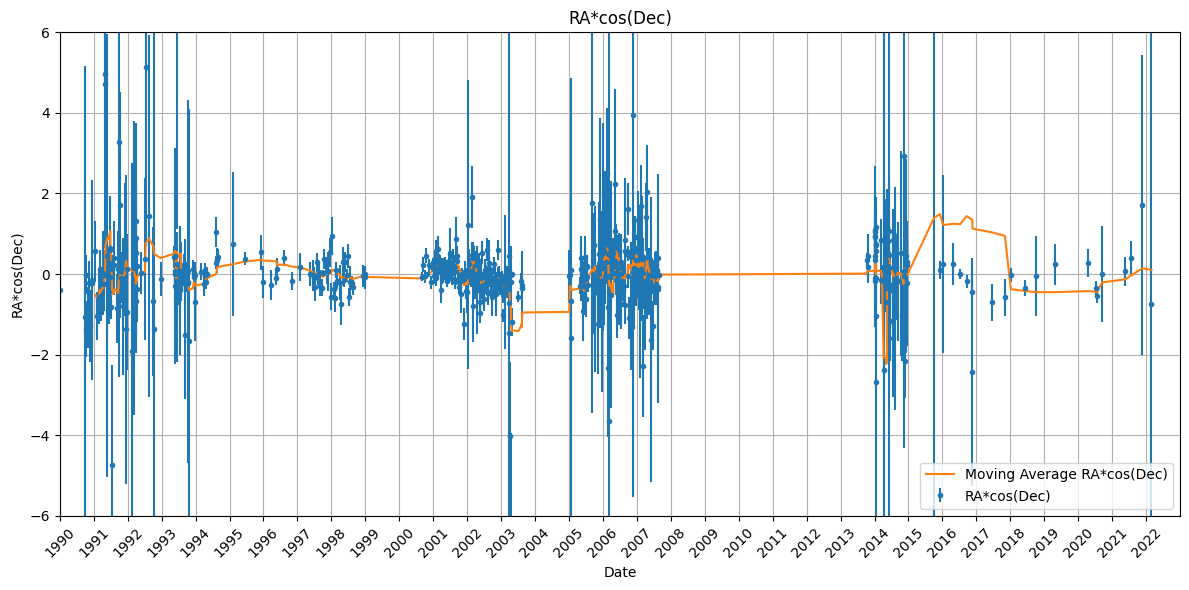

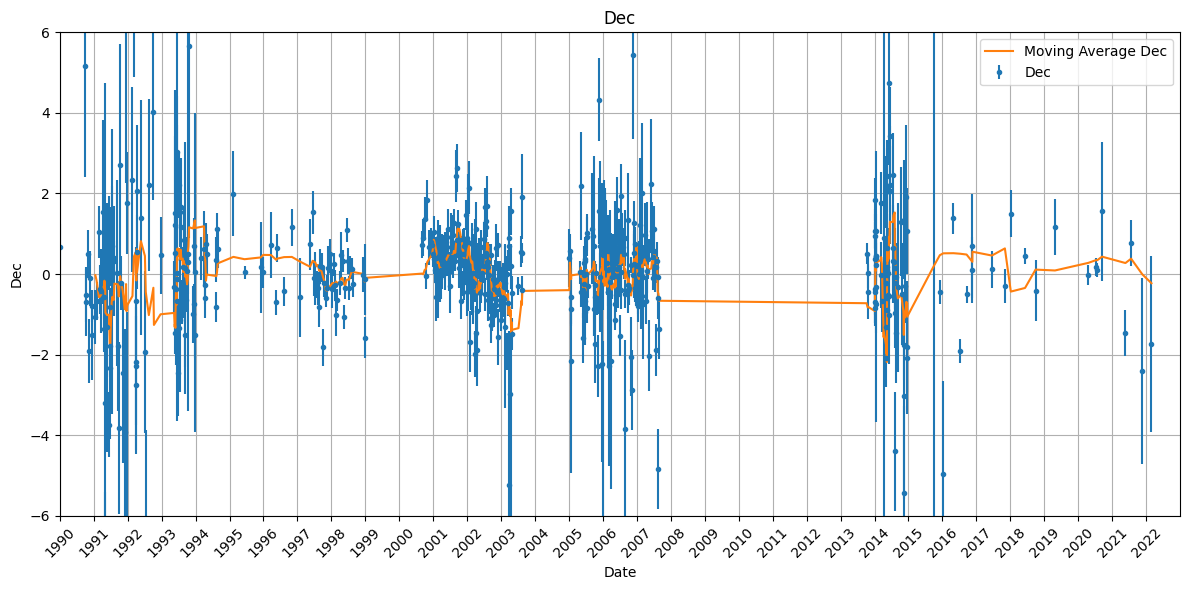

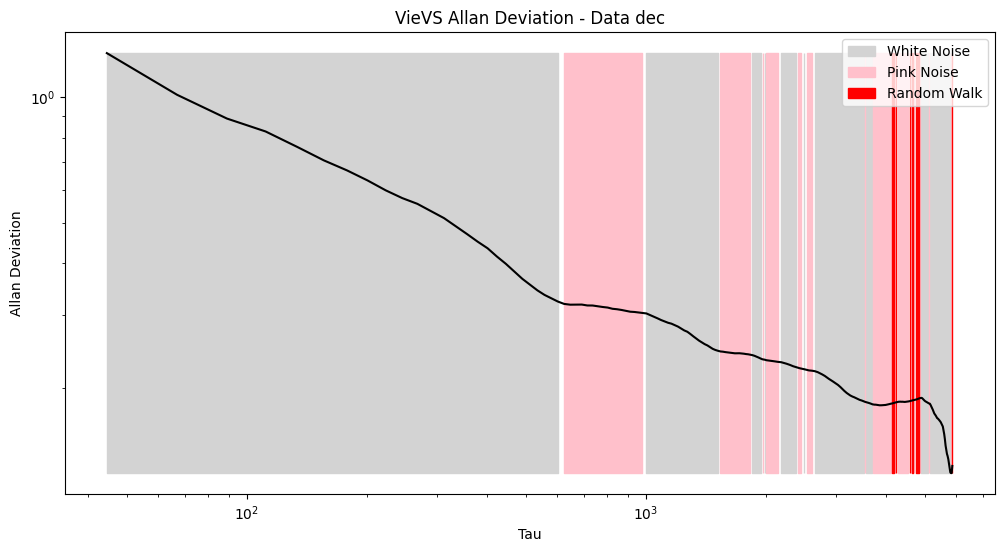

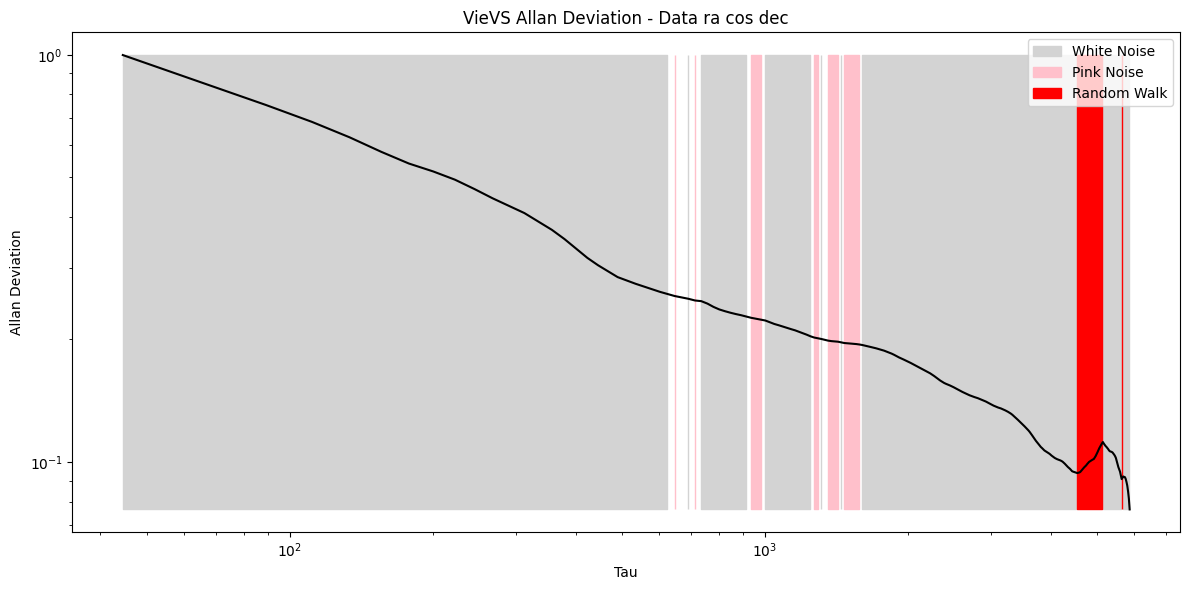

In [2]:
# Set up the plot for RA*cos(Dec)
fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(mjd_dates_cleaned, ra_cos_dec_cleaned, yerr=y_errors_cleaned, fmt='o', 
            markersize=3, label='RA*cos(Dec)')
ax.plot(mjd_dates_ma, ra_cos_dec_ma, label='Moving Average RA*cos(Dec)')
ax.set_xlim(datetime(1990, 1, 1), datetime(2022, 12, 31))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xlabel('Date')
ax.set_ylabel('RA*cos(Dec)')
ax.set_title('RA*cos(Dec)')
ax.set_ylim(-6, 6)
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

# Set up the plot for Dec
fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(mjd_dates_cleaned, dec_cleaned, yerr=dec_errors, fmt='o', markersize=3, label='Dec')
ax.plot(mjd_dates_ma, dec_ma, label='Moving Average Dec')
ax.set_xlim(datetime(1990, 1, 1), datetime(2022, 12, 31))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xlabel('Date')
ax.set_ylabel('Dec')
ax.set_title('Dec')
ax.set_ylim(-6, 6)
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

# Calculate Allan Deviation for data dec
data_dec = dec_cleaned
rate_dec = 1.0 / mean_time_diff
data_type_dec = 'freq'
N_dec = len(data_dec)
taus_dec = 'all'
adev_dec = allantools.oadev(data_dec, rate=rate_dec, data_type=data_type_dec, taus=taus_dec)

# Set up the plot for Allan Deviation - data dec
fig_dec, ax_dec = plt.subplots(figsize=(12, 6))
taus_dec = adev_dec[0][1:]
allan_dev_dec = adev_dec[1][1:]
slopes_dec = np.diff(np.log10(allan_dev_dec)) / np.diff(np.log10(taus_dec))

# Plot Allan Deviation - data dec
ax_dec.loglog(taus_dec, allan_dev_dec, color='black')

# Plot background colors based on slopes - data dec
ax_dec.fill_between(taus_dec[:-1], np.min(allan_dev_dec), np.max(allan_dev_dec), 
                    where=slopes_dec < -0.25, color='lightgray', label='White Noise')
ax_dec.fill_between(taus_dec[:-1], np.min(allan_dev_dec), np.max(allan_dev_dec), 
                    where=((slopes_dec >= -0.25) & (slopes_dec <= 0.25)), color='pink', label='Pink Noise')
ax_dec.fill_between(taus_dec[:-1], np.min(allan_dev_dec), np.max(allan_dev_dec), 
                    where=slopes_dec > 0.25, color='red', label='Random Walk')

ax_dec.set_xlabel('Tau')
ax_dec.set_ylabel('Allan Deviation')
ax_dec.set_title('VieVS Allan Deviation - Data dec')

ax_dec.legend()

# Calculate Allan Deviation for data ra cos dec
data_ra_cos_dec = ra_cos_dec_cleaned
rate_ra_cos_dec = 1.0 / mean_time_diff
data_type_ra_cos_dec = 'freq'
N_ra_cos_dec = len(data_ra_cos_dec)
taus_ra_cos_dec = 'all'
adev_ra_cos_dec = allantools.oadev(data_ra_cos_dec, rate=rate_ra_cos_dec, 
                                   data_type=data_type_ra_cos_dec, taus=taus_ra_cos_dec)

# Set up the plot for Allan Deviation - data ra cos dec
fig_ra_cos_dec, ax_ra_cos_dec = plt.subplots(figsize=(12, 6))
taus_ra_cos_dec = adev_ra_cos_dec[0][1:]
allan_dev_ra_cos_dec = adev_ra_cos_dec[1][1:]
slopes_ra_cos_dec = np.diff(np.log10(allan_dev_ra_cos_dec)) / np.diff(np.log10(taus_ra_cos_dec))

# Plot Allan Deviation - data ra cos dec
ax_ra_cos_dec.loglog(taus_ra_cos_dec, allan_dev_ra_cos_dec, color='black')

# Plot background colors based on slopes - data ra cos dec
ax_ra_cos_dec.fill_between(taus_ra_cos_dec[:-1], np.min(allan_dev_ra_cos_dec), np.max(allan_dev_ra_cos_dec), 
                           where=slopes_ra_cos_dec < -0.25, color='lightgray', label='White Noise')
ax_ra_cos_dec.fill_between(taus_ra_cos_dec[:-1], np.min(allan_dev_ra_cos_dec), np.max(allan_dev_ra_cos_dec),
                           where=((slopes_ra_cos_dec >= -0.25) & (slopes_ra_cos_dec <= 0.25)), 
                           color='pink',label='Pink Noise')
ax_ra_cos_dec.fill_between(taus_ra_cos_dec[:-1], np.min(allan_dev_ra_cos_dec), np.max(allan_dev_ra_cos_dec), 
                           where=slopes_ra_cos_dec > 0.25, color='red', label='Random Walk')

ax_ra_cos_dec.set_xlabel('Tau')
ax_ra_cos_dec.set_ylabel('Allan Deviation')
ax_ra_cos_dec.set_title('VieVS Allan Deviation - Data ra cos dec')

ax_ra_cos_dec.legend()

# Display the plots
plt.tight_layout()
plt.show()